## Creating the dataset

In [39]:
# Importing necessary packages

from random import choices, shuffle, seed
import matplotlib.pyplot as plt

# Setting random seeds for reproducibility
seed(42)

In [44]:
# Utility functions

def IsValid(seq, match = {'(':')', '[':']', '{':'}', '<':'>'}, 
            pad = '.') -> bool:
    """
    Given an input sequence, return whether it is correct.
    """
    stack = []
    for idx, char in enumerate(seq):
        if char in match.keys():
            stack.append(char)
        elif char in match.values():
            if len(stack) == 0:
                return False
            if char == match[stack[-1]]:
                stack.pop()
                continue
            else:
                return False
        else:
            return (idx > 0 and 
                    all(i == pad for i in seq[idx:]) and 
                    len(stack) == 0)
    return len(stack) == 0

def SampleCorrect(n, match = {'(':')', '[':']', '{':'}', '<':'>'}, 
                  pad = '.', MAX_LEN = 10) -> set:
    """
    Create a set of gramatically correct sequences. Works faster than purely random generation.
    """
    res = set()
    while len(res) < n:
        stack = []
        pool = list(match.keys()) + [pad]
        newstr = ""
        while len(newstr) < MAX_LEN:
            if len(stack) == 0:
                toadd = random.choices(pool, k=1)[0]
            else:
                toadd = random.choices(pool + [match[stack[-1]]], k=1)[0]
            if toadd in match.keys():
                stack.append(toadd)
            elif toadd in match.values():
                stack.pop()
            elif toadd == pad:
                newstr += pad*(MAX_LEN - len(newstr))
                break
            newstr += toadd
        if IsValid(newstr):
            res.add(newstr)
    return res

def RealLen(seqs, pad = '.', 
            MAX_LEN = 10) -> list:
    """
    For dataset investigation purposes. 
    Gives the real lenghts (ie without end padding) of 
    a list of sequences as a list of ints.
    """
    lens = []
    for seq in seqs:
        for idx, char in enumerate(reversed(seq)):
            if not (char == pad):
                lens.append(MAX_LEN - idx)
                break
            if idx == MAX_LEN - 1:
                lens.append(0)
                break
    return lens

def count_parameters(model) -> int: 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def performance(outs, groundt, treshold = 0.5) -> dict:
    truepos, trueneg, falseneg, falsepos = 0, 0, 0, 0
    preds = [int(out.item() > treshold) for out in outs.view(-1)]
    for i in range(len(preds)):
        if preds[i] == int(groundt[i].item()):
            if preds[i] == 1:
                truepos += 1
            else:
                trueneg += 1
        elif int(groundt[i].item()) == 1 and preds[i] ==0:
            falseneg += 1
        else:
            falsepos += 1
    precision = truepos/(truepos + falsepos)
    recall = truepos/(truepos + falseneg)
    accuracy = (truepos+trueneg)/len(preds)
    Fscore = 2*precision*recall/(precision+recall)
    perf = {"accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "Fscore": Fscore,
            }
    return perf

def ReadDataset(filename):
    seqs=[]
    with open(filename, 'r') as file:
        while True:
            seq = file.readline()
            if not seq:
                break
            seqs.append(seq.strip())
    labels = [int(IsValid(seq)) for seq in seqs]
    return seqs, labels


We would like to build an appropriately sized dataset on which to train and test our models. As random generation of sequences would result in an extremely small number of correct sequences, we will use our ```SampleCorrect()``` utility function to unbias the dataset and allow the model to see a sufficient number of both postive and negative examples.

We also generate two types of random sequences. One consists of a number of randomly sampled brackets padded at the end by an appropriate number of ```.```'s. The other is generated in a purely random fashion, allowing for padding symbols ```.``` to appear inbetween brackets. This will force the models to learn what padding is. 

In [28]:
# Creating a dataset of 10-character sequences 
# with 4 types of brackets

chars = {'(', ')', '[', ']', '{', '}', '<', '>'}
MAX_LEN = 10

In [7]:
# 10000 correct examples
correct = SampleCorrect(10000, MAX_LEN=MAX_LEN)

# 2^12 = 4096 correctly padded random examples; 
# we expect a small amount of duplicates, 
# and a neglible number (if any) of correct sequences
rand = []
# Iterating over possible sequence lenghts
for k in range(MAX_LEN+1):
    # exponential term ensures we generate more of the longer sequences
    while(len(rand)<2**(k+2)): 
        # Rndomly sampling, padding, and appending
        seq = ''.join(choices(list(chars), k=k))
        rand.append(seq + (MAX_LEN - k)*'.')

# 6000 purely random sequences
chars.add('.')
for i in range(6000):
    seq = ''.join(choices(list(chars), k=MAX_LEN))
    rand.append(seq)

# Combining and labeling
Dataset = list(correct.union(set(rand)))
shuffle(Dataset)
Labels = [int(IsValid(seq)) for seq in Dataset]

# Writing to a file

with open('dataset1.txt', 'w') as file:
    for seq in Dataset:
        file.write(seq + '\n')

print(f'We have created a dataset of {len(Dataset)} sequences, {sum(Labels)} of which are correct.')

We have created a dataset of 20089 sequences, 10000 of which are correct.


Now that we've written the dataset to a file, we can access it (from here of other files/notebooks) without paying the cost of generating it. We will use our utility function ```ReadDataset``` to fetch both the sequences and their labels.

In [49]:
Dataset, Labels = ReadDataset("dataset1.txt")

# Making sure this is the same thing
print(f'We have read a dataset of {len(rD)} sequences, {sum(rL)} of which are correct.')

We have read a dataset of 20089 sequences, 10000 of which are correct.


### Taking a look at the dataset

It is worth exploring and analysing the dataset before we go on to train models on it. For example, we are interested in how the positive examples are spread throughout it. Looking at the graph bellow, we can see the number of correct examples per 100 follows a reasonably normal distribution centred around 50, which is consistent with positive examples constituting just under 50% of the dataset.

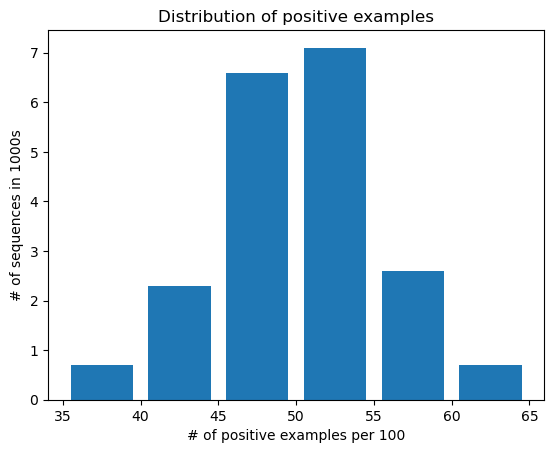

In [50]:
plt.hist([sum(Labels[100*i:100*(i+1)]) for i in range(200)], bins = [35, 40, 45, 50, 55, 60, 65], rwidth=0.8);
plt.title('Distribution of positive examples');
plt.xlabel('# of positive examples per 100');
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], [0, 1, 2, 3, 4, 5, 6, 7]);
plt.ylabel('# of sequences in 1000s');

The lengths of the sequences - that is, how many characters occur before the _final_ padding - is also of interest. In particular, we'd like to know if there is a difference in distributions in that aspect between the correct and incorrect examples. Note that our utility function ```RealLen()``` counts padding symbols in the middle of the sequence towards it's length, i.e. ```(){[]}.().``` is considered length 9.

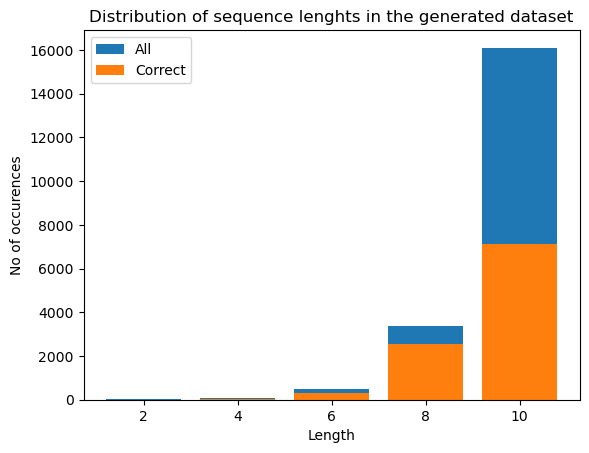

In [61]:
plt.hist(RealLen(Dataset), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='All');
plt.hist(RealLen([i for i in Dataset if IsValid(i)]), bins = [1, 3, 5, 7, 9, 11], rwidth=0.8, label='Correct');
plt.title('Distribution of sequence lenghts in the generated dataset');
plt.xlabel('Length');
plt.ylabel('No of occurences');
# plt.yscale('log');
plt.legend();

We can judge from the graphs above that correct sequences seem to be somewhat over-represented at lengths 4 - 8 (toggling the log-scale on and off helps see this). This can be explained by the way we have generated the dataset, and by the combinatorics of the problem in geeral. It is good to be aware of this apparent bias in our dataset, and observe closely if it results in a "missunderstanding" in the training (for example, a model could learn to associate a large number of padding symbols at the end with a high probability of the sequence being correct, instead of learning the rule that padding symbols at the end are irrelevant). 